# AntennaAnalytics-Arg

La idea es usar el monthly sumLinks output (los sframe dirs dentro de `/output/year/month/sum_links3`) donde tenemos un dataframe de estilo SumLinks con con el siguiente header (solo considerando _OUTgoing calls)

USER|VULNERABLE|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend

CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI

el equivalente al sumlinks de mexico que cuenta agrega todas las llamadas salientes de un user y resume su informacion de comunicacion

El output tendria que tener el siguiente header:
ANTENNA_ID|USERS|VULN_USERS|CALLS|VULN_CALLS

CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend

CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI

## definiciones utilizadas

* *Time* columns are measured in seconds, all other columns are in counts (except the antenna_id cols)
* el analisis es solo para CDRs con usuarios de la TelCo.
* el formato del string para el ANTENNA_ID difiere del raw dataset en que se borro el ultimo char para todas las raw antennas (resultaba que el ultimo char era a veces distinto para una misma antenna)
* el Antenna_id_0 p/c/ user viene dado por el analisis del home_mapping_antenna donde le asignamos una antenan de home en base al uso de las antennas segun un horario particular p/c/user

### la idea es llegar a algo similar a esto
pero sin la info de sms

In [13]:
!head /home/juan/mobility-study/data/mexico_ant2vuln_aggregation.txt

ANTENNA_ID_0|TOTAL_USERS|EPI_USERS|EXP_USERS|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TOTAL_Calls|TOTAL_EPI_Calls|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI|TOTAL_Time|TOTAL_EPI_Time
1|862|338|818|12787|6178|5944|1352028|822011|750888|2474|1332|1208|29923|5014|296803|190709|176422|3588861|663934
2|1106|386|1029|13043|7436|7097|1605549|1025268|832785|2778|1493|1629|33476|5900|361363|228168|197412|4250545|786943
3|948|418|913|18401|8966|8421|2204147|1321580|960480|3767|1891|1621|43067|7279|467231|253443|193268|5400149|913942
4|629|262|602|8878|5733|5691|1166484|992407|729013|2835|1377|1480|25994|5692|341738|216970|201343|3647955|760051
5|506|221|491|5678|3487|3711|612525|427256|417892|1229|902|974|15981|3105|140848|108824|113230|1820575|362902
6|590|283|577|8544|4278|4375|989851|614566|474512|2428|1191|1259|22075|4878|324709|183312|148915|2735865|656936
7|1763|947|1726|21

## Read Sframes

In [10]:
import pandas as pd;
import numpy as np;
import os;
import random;
import graphlab as gl
import time
import datetime
import sys
import subprocess
pd.set_option('display.max_rows', 200)
#esto es para dibujar directo a la notebook
gl.canvas.set_target('ipynb')
rootdir="/home/juan/mobility-study/argentina-scripts"
os.chdir(rootdir)

#los meses a analizar
ms = [11,12,1,2,3]

def get_output_file(month):
    
    output_file = "/home/juan/mobility-study/argentina-scripts/output/2012/{0}/antenna_usage_aggregation.csv".\
    format(month)
    
    return output_file

def get_input_url(month):
    
    input_url = "/home/juan/mobility-study/argentina-scripts/output/2012/{0}/sum_links3".\
    format(month)
    
    return input_url



In [19]:
# set Load params

month =1
input_dir =  get_input_url(month = month)
antenna_output =  get_output_file(month)

!du -sh $input_dir
!ls output/2012/$month/

512M	/home/juan/mobility-study/argentina-scripts/output/2012/1/sum_links3
antenna_usage_aggregation.csv  sum_links__group13_1  sum_links__group3_1
sum_links2_g0tog4_direcO       sum_links__group14_1  sum_links__group4_1
sum_links2_g14tog19_direcO     sum_links__group15_1  sum_links__group5_1
sum_links2_g5tog13_direcO      sum_links__group16_1  sum_links__group6_1
sum_links3		       sum_links__group17_1  sum_links__group7_1
sum_links__group0_1	       sum_links__group18_1  sum_links__group8_1
sum_links__group10_1	       sum_links__group19_1  sum_links__group9_1
sum_links__group11_1	       sum_links__group1_1
sum_links__group12_1	       sum_links__group2_1


# Load antenna lat/long data

In [8]:
antennas_file = '/home/juan/mobility-study/argentina-scripts/data/celdas_limpio.csv'
antennas = gl.SFrame.read_csv( antennas_file, delimiter='|', 
                                     header=True, skip_initial_space=True, 
                                         column_type_hints = [str,float, float, str, str, bool], 
                                         na_values=['NaN'],
                                         usecols = ['CEL_ID','LATITUD',
                                                    'LONGITUD','DEPARTAMENTO','PROVINCIA','EPIDEMIC'],  
                                         error_bad_lines=False,
                                         verbose = False
                                        )                

This non-commercial license of GraphLab Create is assigned to svega@dm.uba.ar and will expire on April 16, 2017. For commercial licensing options, visit https://dato.com/buy/.


2016-07-02 20:23:36,427 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1467491015.log


## Cargar el home antenna mapping p/c/ user en todo el espacio temporal

In [12]:
homeantenna_dirs = [x[0] for x in os.walk('output/') if ("homeantenna" in x[0] and not("sample" in x[0]))]
homeantenna_dirs

['output/homeantenna_sframe_group1_1',
 'output/homeantenna_sframe_group17_1',
 'output/homeantenna_sframe_group2_1',
 'output/homeantenna_sframe_group8_1',
 'output/homeantenna_sframe_group19_1',
 'output/homeantenna_sframe_group0_1',
 'output/homeantenna_sframe_group16_1',
 'output/homeantenna_sframe_group11_1',
 'output/homeantenna_sframe_group10_1',
 'output/homeantenna_sframe_group6_1',
 'output/homeantenna_sframe_group14_1',
 'output/homeantenna_sframe_group12_1',
 'output/homeantenna_sframe_group9_1',
 'output/homeantenna_sframe_group3_1',
 'output/homeantenna_sframe_group4_1',
 'output/homeantenna_sframe_group7_1',
 'output/homeantenna_sframe_group5_1',
 'output/homeantenna_sframe_group15_1',
 'output/homeantenna_sframe_group13_1',
 'output/homeantenna_sframe_group18_1']

In [16]:
%%time
##read homeantenna_data
homeantenna_map =  gl.SFrame()

for home_dir in homeantenna_dirs:
    group_map = gl.load_sframe(home_dir)
    group_map = group_map['USER','ANTENNA_ID_WEEKNIGHT_0']
    #users with str(-1) values are those for which no calls were recorded in that period, thus we have to discard them
    group_map = group_map[group_map['ANTENNA_ID_WEEKNIGHT_0']!='-1']
    homeantenna_map = homeantenna_map.append(group_map)

print(homeantenna_map.shape)

(31475183, 2)
CPU times: user 2min 21s, sys: 43.4 s, total: 3min 5s
Wall time: 18.3 s


In [18]:
homeantenna_map.head()

USER,ANTENNA_ID_WEEKNIGHT_0
4C6862586458547A313548437A74793733685A5737413D3D ...,BA237
742F364F65466756413236674E6B4449766369646D673D3D ...,C1664
587442774E45766C733553526C376335456566566D413D3D ...,SF449
44713446416D556448624A4B6B306E416452643655673D3D ...,ME068
6552796530623052497A6A75724C514B7276563576673D3D ...,CO670
37556C7676356A38707036774C4A44373335325555773D3D ...,C2366
3444617664304C5676444B41373152372F49754946513D3D ...,BA820
714652715A4B64544C32695371614F56355047364A773D3D ...,CF001
4761514E637346704F31617877506F4B494F33682B773D3D ...,JU200
6154474F55662F4656444A68377A726F424D4A3043773D3D ...,NQ003


In [21]:
#cargar input_table
table = gl.load_sframe(input_dir)

In [23]:
%%time
# mergeamos con home_antenna data 
table = table.join(homeantenna_map, on = 'USER' ,how='left')

CPU times: user 5min 23s, sys: 31.3 s, total: 5min 55s
Wall time: 3min 11s


In [24]:
%%time
count_nulls = table[ table['ANTENNA_ID_WEEKNIGHT_0'] == None ]
print(count_nulls.shape)

(679770, 15)
CPU times: user 34.4 s, sys: 18.6 s, total: 53 s
Wall time: 4.17 s


In [25]:
#tiro los que no tengo antenna
table = table[ table['ANTENNA_ID_WEEKNIGHT_0'] != None ]

In [27]:
aggregator_dict = dict()
for col in table.column_names():
    if col == 'ANTENNA_ID_WEEKNIGHT_0':
        continue
    if col == 'USER':
        aggregator_dict[col] = gl.aggregate.COUNT()
    else:
        aggregator_dict[col] = gl.aggregate.SUM(col)
aggregator_dict

{'CallsWeekDay': ('__builtin__sum__', ['CallsWeekDay']),
 'CallsWeekDay_EPI': ('__builtin__sum__', ['CallsWeekDay_EPI']),
 'CallsWeekEnd': ('__builtin__sum__', ['CallsWeekEnd']),
 'CallsWeekEnd_EPI': ('__builtin__sum__', ['CallsWeekEnd_EPI']),
 'CallsWeekNight': ('__builtin__sum__', ['CallsWeekNight']),
 'CallsWeekNight_EPI': ('__builtin__sum__', ['CallsWeekNight_EPI']),
 'TimeWeekDay': ('__builtin__sum__', ['TimeWeekDay']),
 'TimeWeekDay_EPI': ('__builtin__sum__', ['TimeWeekDay_EPI']),
 'TimeWeekEnd': ('__builtin__sum__', ['TimeWeekEnd']),
 'TimeWeekEnd_EPI': ('__builtin__sum__', ['TimeWeekEnd_EPI']),
 'TimeWeekNight': ('__builtin__sum__', ['TimeWeekNight']),
 'TimeWeekNight_EPI': ('__builtin__sum__', ['TimeWeekNight_EPI']),
 'USER': ('__builtin__count__', ['']),
 'VULNERABLE': ('__builtin__sum__', ['VULNERABLE'])}

In [74]:
%%time
antenna_usage = table.groupby('ANTENNA_ID_WEEKNIGHT_0', aggregator_dict)

CPU times: user 38.2 s, sys: 7.46 s, total: 45.6 s
Wall time: 3.41 s


In [75]:
antennas.head()

CEL_ID,LATITUD,LONGITUD,DEPARTAMENTO,PROVINCIA,EPIDEMIC
B1061,-36.339,-56.7468,La_Costa,Buenos_Aires,0
B1062,-33.4578,-60.0522,Ramallo,Buenos_Aires,0
BA001,-35.1641,-60.0866,Veinticinco_de_Mayo,Buenos_Aires,0
BA003,-35.4275,-60.1538,Veinticinco_de_Mayo,Buenos_Aires,0
BA004,-35.9,-60.7275,Veinticinco_de_Mayo,Buenos_Aires,0
BA006,-35.2355,-60.8283,Nueve_de_Julio,Buenos_Aires,0
BA007,-35.2894,-61.3972,Nueve_de_Julio,Buenos_Aires,0
BA010,-35.6458,-60.7036,Nueve_de_Julio,Buenos_Aires,0
BA013,-37.1577,-63.2363,Adolfo_Alsina,Buenos_Aires,0
BA015,-37.9641,-60.4202,Adolfo_Gonzales_Chaves,Buenos_Aires,0


In [76]:
# renombro columnas para tener consistencia con otras tablas
antenna_usage.rename({'ANTENNA_ID_WEEKNIGHT_0':'CELL_ID', 
                     'VULNERABLE':'VULN_USERS',
                     'USER':'USERS'})

CELL_ID,TimeWeekEnd_EPI,TimeWeekEnd,CallsWeekDay_EPI,CallsWeekDay,CallsWeekNight,TimeWeekNight_EPI,CallsWeekEnd_EPI
C1501,68347,2656384,1642,69769,22281,86649,425
BA629,7609,530932,181,14272,5798,13345,74
C2352,2761,142247,38,2561,788,2029,26
CO609,324033,2609634,12123,85016,28875,382065,3219
CF565,0,1749,2,126,17,0,0
SF307,38665,2552385,711,66235,26876,44545,271
C1752,63155,1530147,756,30461,12278,66397,359
SL046,458074,289295,8651,4894,2749,585900,5336
SF984,49718,3943738,2038,126541,41433,45361,499
C1322,18145,1142887,238,26116,10153,24142,155


In [80]:
a = range(0,76)
sum(a)

2850

In [81]:
call_columns = [col for col in antenna_usage.column_names() if "Call" in col ]
epi_call_columns = [col for col in antenna_usage.column_names() if "Call" in col and("EPI" in col)]
#call_columns, epi_call_columns
antenna_usage['CALLS']= antenna_usage[call_columns]\
            .apply(lambda x: sum([ x[col] for col in call_columns ]) )
antenna_usage['VULN_CALLS']= antenna_usage[epi_call_columns]\
            .apply(lambda x: x[epi_call_columns[0]]+ x[epi_call_columns[1]]+ x[epi_call_columns[2]] )

In [83]:
## consitency check
(antenna_usage['CALLS']>=antenna_usage['VULN_CALLS']).all()


True

In [84]:
#save this version of database
antenna_usage.export_csv(antenna_output, delimiter='|') 

In [85]:
!head $antenna_output
!wc -l $antenna_output
!du -ha $antenna_output

CELL_ID|TimeWeekEnd_EPI|TimeWeekEnd|CallsWeekDay_EPI|CallsWeekDay|CallsWeekNight|TimeWeekNight_EPI|CallsWeekEnd_EPI|TimeWeekDay|TimeWeekDay_EPI|USERS|CallsWeekEnd|CallsWeekNight_EPI|TimeWeekNight|VULN_USERS|CALLS|VULN_CALLS
C1501|68347|2656384|1642|69769|22281|86649|425|6912241|205827|1988|25360|445|3233796|269|119922|2512
BA629|7609|530932|181|14272|5798|13345|74|1122060|19352|576|7246|71|602020|42|27642|326
C2352|2761|142247|38|2561|788|2029|26|325374|5656|91|1079|18|134991|12|4510|82
CO609|324033|2609634|12123|85016|28875|382065|3219|7515263|1201289|1817|30537|2980|3186755|1151|162750|18322
CF565|0|1749|2|126|17|0|0|11714|25|7|35|0|1096|1|180|2
SF307|38665|2552385|711|66235|26876|44545|271|5819752|67847|2160|31625|281|2906552|302|125999|1263
C1752|63155|1530147|756|30461|12278|66397|359|3103032|100785|1178|15165|273|1528728|133|59292|1388
SL046|458074|289295|8651|4894|2749|585900|5336|644926|838897|445|2629|5333|390282|395|29592|19320
SF984|49718|3943738|2038|126541|41433|45361|499|

In [86]:
perc = 0.98
col = 'USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4466     |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |    477068.0   |   Yes    |
|        Mean        | 2107.86654725 |   Yes    |
|        Sum         |   9413732.0   |   Yes    |
|      Variance      | 62765254.2227 |   Yes    |
| Standard Deviation | 7922.45253837 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      2564     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+----+----+----+----+----+----+----+----+----+----+
| value | 1  | 3  | 4  | 5  | 11 | 10 | 28 | 36 | 2  | 13 |
+-------+----+----+----+----+----+----+----+----+----+----+
| count | 21 | 16 | 16 | 15 | 14 | 13 | 12 | 12 | 11 | 11 |
+-------+----+----+----+----+----+----+----+----+----+----+

Quantiles: 
+-----+-----+-

In [87]:
perc = 0.98
col = 'VULN_USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4466     |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         |    69467.0    |   Yes    |
|        Mean        | 619.427227944 |   Yes    |
|        Sum         |   2766362.0   |   Yes    |
|      Variance      | 4062319.84255 |   Yes    |
| Standard Deviation | 2015.51974502 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      1303     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+----+----+----+----+----+----+----+----+----+
| value |  0  | 1  | 4  | 2  | 3  | 5  | 7  | 6  | 11 | 8  |
+-------+-----+----+----+----+----+----+----+----+----+----+
| count | 105 | 73 | 58 | 54 | 48 | 40 | 38 | 35 | 29 | 29 |
+-------+-----+----+----+----+----+----+----+----+----+----+

Quantiles: 
+-----+--

In [89]:
perc = 0.98
col = 'CALLS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+------------------+----------+
|        item        |      value       | is exact |
+--------------------+------------------+----------+
|       Length       |       4466       |   Yes    |
|        Min         |       1.0        |   Yes    |
|        Max         |    21312648.0    |   Yes    |
|        Mean        |  130087.388267   |   Yes    |
|        Sum         |   580970276.0    |   Yes    |
|      Variance      | 1.4274964053e+11 |   Yes    |
| Standard Deviation |  377822.234034   |   Yes    |
|  # Missing Values  |        0         |   Yes    |
|  # unique values   |       4383       |    No    |
+--------------------+------------------+----------+

Most frequent items:
+-------+----+---+----+----+------+------+-----+-----+-----+-----+
| value | 58 | 3 | 24 | 21 | 1082 | 6153 | 279 | 107 | 557 | 553 |
+-------+----+---+----+----+------+------+-----+-----+-----+-----+
| count | 3  | 3 | 3  | 3  |  3   |  2   |  2  |  2  |  2  |  2  |
+-------+----+---+--

# VULN users to users ratio

In [91]:
perc = 0.98
col = 'USERS'
vuln_col = 'VULN_USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)


a = antenna_usage[antenna_usage[col]<quant][col]
b = antenna_usage[antenna_usage[col]<quant][vuln_col]

(b/a).show()

In [95]:
perc = 0.98
col = 'CALLS'
vuln_col = 'VULN_' + col

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)


a = antenna_usage[antenna_usage[col]<quant][col]
b = antenna_usage[antenna_usage[col]<quant][vuln_col]

(b/a).show()

In [96]:
# paso a trabajar con pandas y seaborn

import seaborn as sns
antenna_usage = antenna_usage.to_dataframe()
color_palette = sns.color_palette()
#sns.palplot(color_palette)
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

%matplotlib inline

In [98]:
quant = 0.98

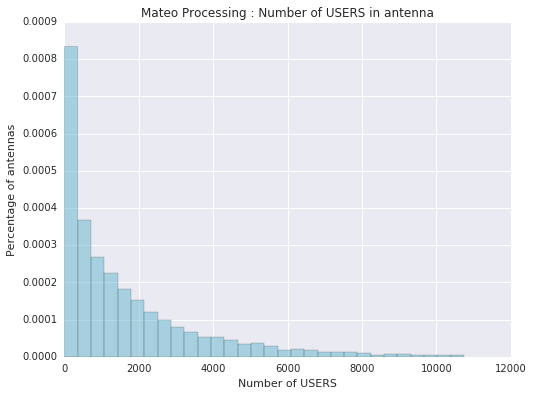

In [99]:
col = 'USERS'
vuln_col = 'VULN_' + col
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('Number of {c}'.format(c=col));
ax.set_ylabel('Percentage of antennas');
ax.set_title('Mateo Processing : Number of {c} in antenna'.format(c = col))

#ax.set_title('Argentina antenna\'s normed histogram : Time_delta (click to install) for lieferheld ios 888\
# where clicks are from {pd.month}/{pd.day} to {sd.month}/{sd.day}'\
#              .format(pd = past_date, sd = start_date));
#ax.legend();



(antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]).hist(bins=30,normed =True, 
                color = color_palette[5], alpha = 0.5)

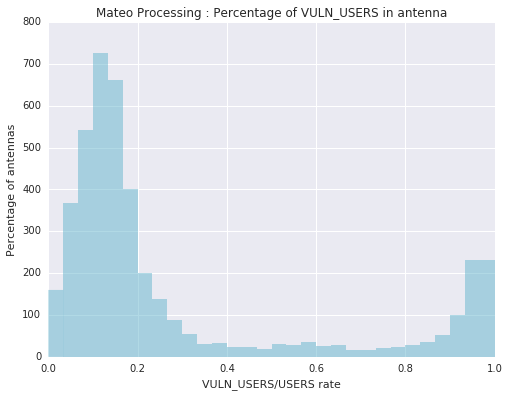

In [131]:
quant = 0.98
col = 'USERS'
vuln_col = 'VULN_' + col
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('{vc}/{c} rate'.format(c=col, vc = vuln_col));
ax.set_ylabel('Percentage of antennas');

ax.set_title('Mateo Processing : Percentage of {vc} in antenna'.format(vc = vuln_col))

a = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]
b = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = False, 
                  color = color_palette[5], alpha = 0.5, lw = 0)


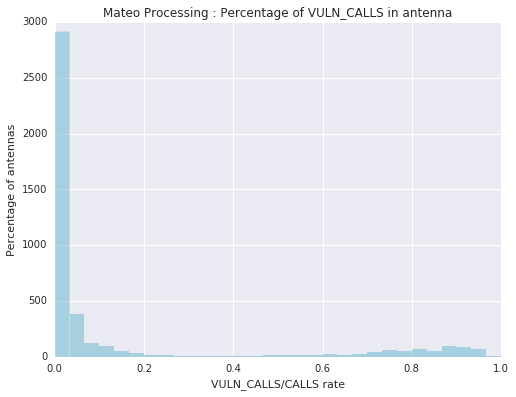

In [132]:
quant = 0.98
col = 'CALLS'
vuln_col = 'VULN_' + col

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('{vc}/{c} rate'.format(c=col, vc = vuln_col));
ax.set_ylabel('Percentage of antennas');

ax.set_title('Mateo Processing : Percentage of {vc} in antenna'.format(vc = vuln_col))

a = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]
b = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = False, 
                  color = color_palette[5], alpha = 0.5, lw = 0)


In [101]:
!ls /home/juan/mobility-study/data/

mexico_ant2vuln_aggregation.txt


In [18]:
perc = 0.99
col = 'calls'

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+-------------------+----------+
|        item        |       value       | is exact |
+--------------------+-------------------+----------+
|       Length       |        4466       |   Yes    |
|        Min         |        0.0        |   Yes    |
|        Max         |     20876596.0    |   Yes    |
|        Mean        |   109768.642857   |   Yes    |
|        Sum         |    490226759.0    |   Yes    |
|      Variance      | 1.30605894118e+11 |   Yes    |
| Standard Deviation |   361394.374773   |   Yes    |
|  # Missing Values  |         0         |   Yes    |
|  # unique values   |        4328       |    No    |
+--------------------+-------------------+----------+

Most frequent items:
+-------+----+---+------+----+---+-----+-----+----+------+-----+
| value | 24 | 2 | 1371 | 58 | 1 | 634 | 198 | 25 | 4677 | 161 |
+-------+----+---+------+----+---+-----+-----+----+------+-----+
| count | 5  | 4 |  3   | 3  | 3 |  3  |  3  | 3  |  3   |  3  |
+-------+----+-

In [19]:
perc = 0.95
col = 'vuln_calls'

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4466     |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         |   2982549.0   |   Yes    |
|        Mean        | 20318.7454098 |   Yes    |
|        Sum         |   90743517.0  |   Yes    |
|      Variance      | 6666580349.45 |   Yes    |
| Standard Deviation | 81649.1295082 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      3038     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+----+----+----+----+----+----+----+----+----+
| value |  0  | 1  | 2  | 3  | 4  | 12 | 7  | 14 | 63 | 5  |
+-------+-----+----+----+----+----+----+----+----+----+----+
| count | 105 | 29 | 22 | 20 | 16 | 15 | 13 | 11 | 11 | 11 |
+-------+-----+----+----+----+----+----+----+----+----+----+

Quantiles: 
+-----+--

In [ ]:
perc = 0.95
col = 'calls'
vuln_col = "vuln_" + 

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


a = table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]
b = table_arg[table_arg[col] < table_arg[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = True, 
                  color = color_palette[5], alpha = 0.5, lw = 0)

## Kolmogorov Smirnov 2-sample test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

Un test donde la H0 es: las muestras provienen de la misma distribucion

In [114]:
#load caro's arg dataset
caro_antenna_usage  = pd.read_csv("data/users_per_antenna/calls/gran_chaco_2012{m:0=2d}_out.csv".format(m = month),
                #engine = 'c',
                sep = '|',
                header = 0,
                index_col=0,
                usecols = ['antenna','users','vuln_users','calls','vuln_calls']
            )


In [116]:
# usamos la mismas lables para las columnas
caro_antenna_usage = caro_antenna_usage.rename(columns={'users':'USERS','vuln_users':'VULN_USERS','calls':'CALLS',
                                   'vuln_calls':'VULN_CALLS'})

In [117]:
caro_antenna_usage.head()

,USERS,VULN_USERS,CALLS,VULN_CALLS
antenna,,,,
0,7461,1129,0,0
2,12945,1624,174442,5425
3,379,58,31821,520
4,1266,1249,205010,167685
5,710,67,118932,456


In [119]:
caro_antenna_usage.columns.values

array(['USERS', 'VULN_USERS', 'CALLS', 'VULN_CALLS'], dtype=object)

In [123]:
antenna_usage[['USERS', 'VULN_USERS', 'CALLS', 'VULN_CALLS']].head(15)

,USERS,VULN_USERS,CALLS,VULN_CALLS
0,1988,269,119922,2512
1,576,42,27642,326
2,91,12,4510,82
3,1817,1151,162750,18322
4,7,1,180,2
5,2160,302,125999,1263
6,1178,133,59292,1388
7,445,395,29592,19320
8,3453,487,217588,3014
9,886,105,47747,510


In [129]:
from scipy.stats import ks_2samp
col = 'CALLS'
vuln_col = "VULN_" +col

for c in ['CALLS','VULN_CALLS','USERS','VULN_USERS']:
    print('Column {c}'.format(c=c))
    x = antenna_usage[c]
    y = caro_antenna_usage[c]
    print(ks_2samp(x, y))

Column CALLS
Ks_2sampResult(statistic=0.25004200561379808, pvalue=7.1402745942295197e-123)
Column VULN_CALLS
Ks_2sampResult(statistic=0.21105145590811569, pvalue=1.1592316537900495e-87)
Column USERS
Ks_2sampResult(statistic=0.43030863767572181, pvalue=0.0)
Column VULN_USERS
Ks_2sampResult(statistic=0.34115086538519818, pvalue=2.308188097717712e-228)


In [137]:
for rate in [('CALLS','VULN_CALLS'),('USERS','VULN_USERS')]:
    
    c = rate[0]
    vc = rate[1]

    x = antenna_usage[vc]/ antenna_usage[c]
    y = caro_antenna_usage[vc]/caro_antenna_usage[c]
    
    print('Test between both datasets\' rate of {vc}/{c} '.format(c=c,vc=vc))

    print(ks_2samp(x, y))

Test between both datasets' rate of VULN_CALLS/CALLS 
Ks_2sampResult(statistic=0.05435451903398314, pvalue=3.2720061169061977e-06)
Test between both datasets' rate of VULN_USERS/USERS 
Ks_2sampResult(statistic=0.18920943099806631, pvalue=1.5358985955594945e-70)
